### This notebook contains code to generate all figures with neural recording data, with the exception of Extended Data Fig. 5, which can be found in glm_analysis.ipynb

In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from scipy import odr
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from scipy.linalg import subspace_angles
from scipy.optimize import curve_fit
from scipy.stats import special_ortho_group
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import AnovaRM, anova_lm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.decomposition import PCA, NMF, FactorAnalysis
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import pairwise_distances, roc_auc_score

import scikit_posthocs as sp
import os
import joblib
import pickle
import dill
from datetime import datetime, date
import cmocean
import fitz
from load_processed import load_processed, Strat
from neuralUtils import *
from analysisUtils import *
from analysis_by_class import *
from plot_3d import *
import sys
sys.path.append('../utils')
from db import get_db_info, create_connection, execute_sql, select_db, NumpyEncoder
from plotting import *
from protocols import load_params
from matio import loadmat
sys.path.append('../behavior_analysis')
from traceUtils import check_stats, setUpLickingTrace
from drl_model_predictions import *
import sqlite3
import plotly.graph_objects as go
import warnings
import hashlib
import json
import psutil
import tensortools as tt
import multiprocessing as mp
import itertools

# for decoding 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score, cross_validate, \
    cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeCV
from sklearn.metrics import confusion_matrix, r2_score
import time
from streams import DataStream, extract_data_streams

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Choose which figure to load data for and plot

In [3]:
plot_fig = 'fig2'  # choose between fig2', 'fig3', 'fig4', 'EDfig8', 'Bernoulli', or 'DiverseDists'

In [4]:
plt.style.use('paper_export') # located in utils folder. copy to matplotlib settings folder

In [5]:
params = {       
    # 'fig2' will also generate ED Figures 2, 3, 4a-f, and 7n-o 
    'fig2': {'table': 'ephys',
             'activity_type': 'spks',
             'manipulation': 'combined',
             'protocol': 'SameRewDist',
             'class_name': 'helper',
             'class_labels': ['all'],
             'class_colors': ['k'],
             'bm': True,  # whether to decode mouse-by-mouse
             'mac': False,  # match across classes, for decoding (ignored, because only one class)
             'mar': True,  # match across regions, for decoding
             'psd': False  # use simultaneously recorded neurons
             # class_name = 'cell_types'
             # class_labels = ['MSN', 'FSI']
            },
    'fig3': {'table': 'ephys',
             'activity_type': 'spks',
             'manipulation': '6-OHDA',
             'protocol': 'SameRewDist',
             'class_name': 'lesion',
             'class_labels': ['control', 'lesioned'],
             'class_colors': ['#005363', '#FF69B4'],
             'bm': True,  # whether to decode mouse-by-mouse
             'mac': True,  # match across classes, for decoding (use same number of neurons in lesioned vs. control)
             'mar': False,  # match across regions, for decoding (ignored, because only one region)
             'psd': True  # use pseudo-pops
            },
    # 'fig4' will also generate ED Figure 10a-b, d-e
    'fig4': {'table': 'imaging',
             'activity_type': 'spks',
             'manipulation': 'virus',
             'protocol': 'SameRewDist',
             'class_name': 'genotype',
             'class_labels': ['D1-Cre','A2a-Cre'],
             'class_colors': ['#FFA001', '#0A704E'],
             'rois': ['All Subregions'],
             'bm': False,  # pool across mice
             'mac': True,  # match across classes, for decoding (use same number of neurons in D1 vs. D2)
             'mar': False,  # match across regions, for decoding (ignored, becaues only one region)
             'psd': True  # use pseudo-pops
            },
    'EDfig8': {'table': 'ephys',
             'activity_type': 'spks',
             'protocol': 'SameRewVar',
             'class_name': 'helper',
             'class_labels': ['all'],
             'class_colors': ['k'],
             'bm': True,  # whether to decode mouse-by-mouse
             'mac': False,  # match across classes, for decoding (ignored, because only one class)
             'mar': True,  # match across regions, for decoding
             'psd': True  # use pseudo-pops
            },
    'Bernoulli': {'table': 'ephys',
             'activity_type': 'spks',
             'protocol': 'Bernoulli',
             'class_name': 'helper',
             'class_labels': ['all'],
             'class_colors': ['k']
            },
    'DiverseDists': {'table': 'ephys',
             'activity_type': 'spks',
             'protocol': 'DiverseDists',
             'class_name': 'helper',
             'class_labels': ['all'],
             'class_colors': ['k']
            }
}

In [6]:
# bring correct parameters into namespace
for var in params[plot_fig].keys():
    exec("{} = params[plot_fig]['{}']".format(var, var))

# Extract all relevant ephys recording sessions from database

Gets stored in `rets`, a list of tuples.

In [7]:
paths = get_db_info()
colors, protocol_info, periods, kwargs = load_params(protocol)
if 'manipulation' in params[plot_fig]: kwargs['manipulation'] = manipulation 

# create SQL query based on keyword arguments passed to function
_, sql = construct_where_str(protocol, kwargs, table)
rets = execute_sql(sql, paths['db'])

# handle stats kwarg case, which requires reading in the entire JSONified string of the table
alpha = periods['alpha']
rets = check_stats(rets, kwargs['stats'], protocol_info['pairs_to_check'], alpha)

# plot order
po = np.argsort(protocol_info['mean'][:protocol_info['n_trace_types']])
pou = np.insert(po, protocol_info['n_trace_types'], protocol_info['n_trace_types'])  # including unexpected reward

In [8]:
ret_df = pd.DataFrame(rets, columns=rets[0].keys())

In [9]:
ret_df

,name,exp_date,figure_path,behavior_path,file_date_id,file_date,processed_data_path,meta_time,ncells,stats,...,sid,rid,exp_date,probe1_AP,probe1_ML,probe1_DV,significance,genotype,n_trials_used,n_trials_used
0,AL39,20210930,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20210930,20210930,/n/holystore01/LABS/uchida_users/Users/alowet/...,111731,76,"{""F_half_sec"": 10.5172233178893, ""F_full_trace...",...,23,1,20210930,1.1,-1.5,5.4590,1,BL/6J,219,219
1,AL39,20211001,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20211001,20211001,/n/holystore01/LABS/uchida_users/Users/alowet/...,125415,87,"{""F_half_sec"": 67.13292474303205, ""F_full_trac...",...,24,1,20211001,1.1,-1.4,5.4590,1,BL/6J,274,274
2,AL39,20211002,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20211002,20211002,/n/holystore01/LABS/uchida_users/Users/alowet/...,152747,84,"{""F_half_sec"": 120.36971890630367, ""F_full_tra...",...,25,1,20211002,1.1,-1.5,5.3036,1,BL/6J,305,305
3,AL39,20211003,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20211003,20211003,/n/holystore01/LABS/uchida_users/Users/alowet/...,170128,153,"{""F_half_sec"": 168.8136836179428, ""F_full_trac...",...,26,1,20211003,1.1,-1.5,5.0899,1,BL/6J,298,298
4,AL39,20211004,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20211004,20211004,/n/holystore01/LABS/uchida_users/Users/alowet/...,143640,85,"{""F_half_sec"": 15.730414419517325, ""F_full_tra...",...,27,1,20211004,0.7,-1.6,5.5090,1,BL/6J,292,292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,AL82,20220917,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20220917,20220917,/n/holystore01/LABS/uchida_users/Users/alowet/...,175021,285,"{""F_half_sec"": 4.366736020962001, ""F_full_trac...",...,28,1,20220917,1.1,-1.8,5.2388,1,BL/6J,230,230
67,AL83,20220912,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20220912,20220912,/n/holystore01/LABS/uchida_users/Users/alowet/...,122407,426,"{""F_half_sec"": 9.798194928492173, ""F_full_trac...",...,31,1,20220912,1.1,-1.8,5.3083,1,BL/6J,212,212
68,AL83,20220913,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20220913,20220913,/n/holystore01/LABS/uchida_users/Users/alowet/...,121524,393,"{""F_half_sec"": 39.758518037112225, ""F_full_tra...",...,32,1,20220913,1.1,-1.8,5.4785,1,BL/6J,235,235
69,AL83,20220914,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20220914,20220914,/n/holystore01/LABS/uchida_users/Users/alowet/...,141241,382,"{""F_half_sec"": 43.87738519626594, ""F_full_trac...",...,33,1,20220914,1.1,-1.8,5.1589,1,BL/6J,272,272


# Load in each valid session

In [10]:
spec = str(manipulation) + '_' if 'manipulation' in params[plot_fig] else ''

if table == 'ephys':
    spec += kwargs['probe1_region']
elif 'genotype' in kwargs:
    spec += kwargs['genotype'].split()[0]
elif table == 'imaging':
    spec += 'combined'
    
# hash rets consistently from machine to machine
dhash = hashlib.md5()
encoded = json.dumps(kwargs, sort_keys=True, cls=NumpyEncoder).encode()
dhash.update(encoded)
hashed = dhash.hexdigest()

# save variables
save_path = os.path.join(paths['neural_fig_roots'][1], '_'.join([protocol, table, spec, activity_type + '.sav']))

In [14]:
if os.path.exists(save_path):
    print('Found saved vars at {}.'.format(save_path))
    with open(save_path, 'rb') as f:
        d = joblib.load(f)    
else:
    raise Exception(f'Could not find data in {save_path}. Ensure that data has been copied into the relevant folder, or change `save_path`.')

Found saved vars at ../../data/neural-plots/SameRewDist_ephys_combined_striatum_spks.sav.


In [15]:
# bring loaded variables into namespace
for var in d.keys():
    exec("{} = d['{}']".format(var, var))

del d
# assert n_rets == len(rets)

In [16]:
if table == 'ephys':
    
    neuron_info, reg_labels = assign_str_regions_from_kim(neuron_info)
    neuron_info['hemi'] = False
    neuron_info.loc[neuron_info['mls'] > 0, 'hemi'] = True
    mice = np.unique(neuron_info['names'])
    norm_means = 'means'
    norm_stds = 'stds'
    mouse_colors = get_mouse_colors(protocol)

    if class_name == 'helper':
        rois = reg_labels + ['All Subregions']
        neuron_info['helper'] = 'all'
        
    elif class_name == 'lesion':
        rois = ['All Subregions']  # this is mostly lAcbSh and VLS, since it's restricted to lesion
        neuron_info['lesion'] = None
        lesion_rets = select_db(paths['db'], 'lesion', '*', 'lesion="6-OHDA"', (), unique=False)
        for lret in lesion_rets:
            if lret['name'] in mice:
                larea_mouse = np.logical_and.reduce([neuron_info.depths > lret['bregma_bottom'], 
                                                     neuron_info.depths < lret['bregma_top'],
                                                     neuron_info.names == lret['name']])
                neuron_info.loc[np.logical_and(larea_mouse, neuron_info.hemi), 'lesion'] = 'lesioned'
                neuron_info.loc[np.logical_and(larea_mouse, ~neuron_info.hemi), 'lesion'] = 'control'
    
else:
    rois = ['All Subregions']
    neuron_info = pd.DataFrame(neuron_info)
    mice = np.unique(neuron_info['names'])
    norm_means = 'spks_means'
    norm_stds = 'spks_stds'
    mouse_colors = get_mouse_colors(protocol, imaging=True)

cue_resps_norm = (cue_resps - np.array(neuron_info[norm_means]).reshape(1, -1, 1, 1)) / np.array(neuron_info[norm_stds]).reshape(1, -1, 1, 1)
X_means_norm = (X_means - np.array(neuron_info[norm_means]).reshape(1, -1, 1)) / np.array(neuron_info[norm_stds]).reshape(1, -1, 1)

# Trial-averaged analyses: PCA and RDA
## Generated plots include Fig. 2a,i-l, 3d-f,h, 4i-q, ED Fig 8c-e
### Can run this on any data set

In [78]:
trunc_df = ret_df[ret_df['ncells'] > 5].reset_index() # needed for imaging sessions with low cell count
n_components = 2
n_pca_splits = 4

all
computed projection


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


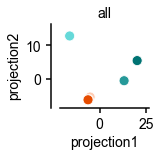

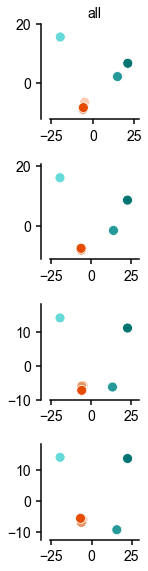

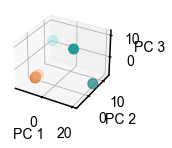

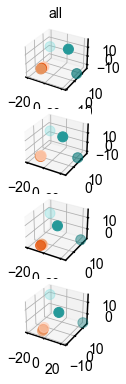

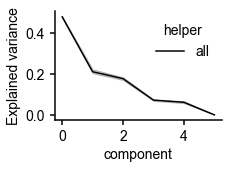

In [79]:
# pooling across all mice (used for imaging data)
pooled_pca, pooled_dists, pooled_avg, pooled_rda, pooled_rdaavg, pooled_var = reduce_pool_mice(
    neuron_info, cue_resps_norm, class_name, class_labels, protocol_info, colors, class_colors,
    late_trace_ind, n_components, n_pca_splits, activity_type=activity_type)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


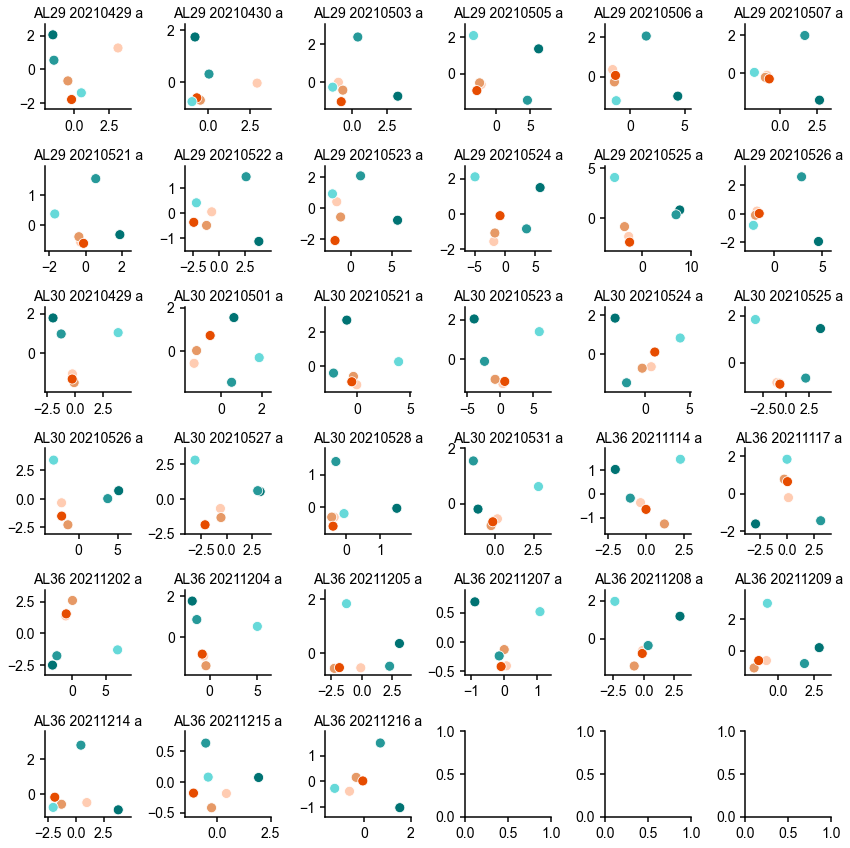

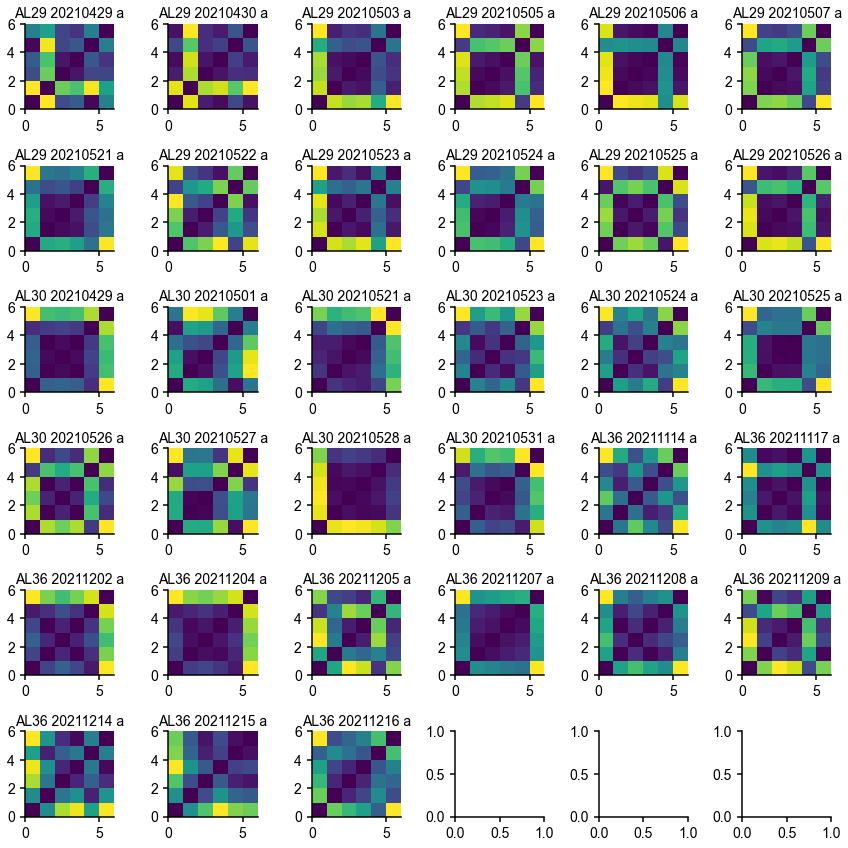

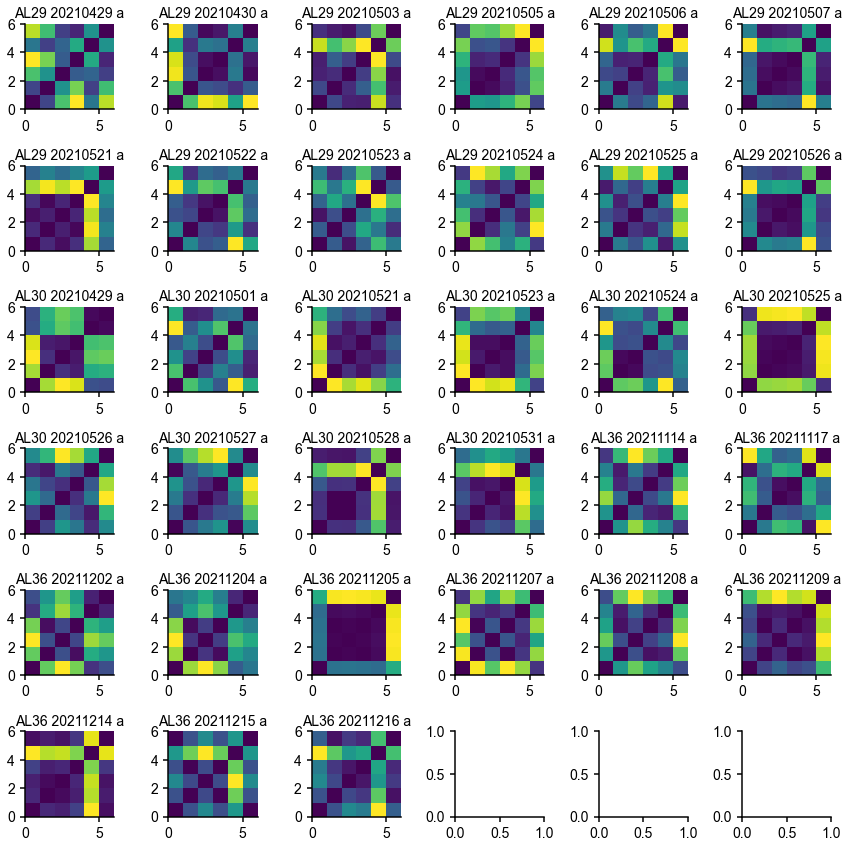

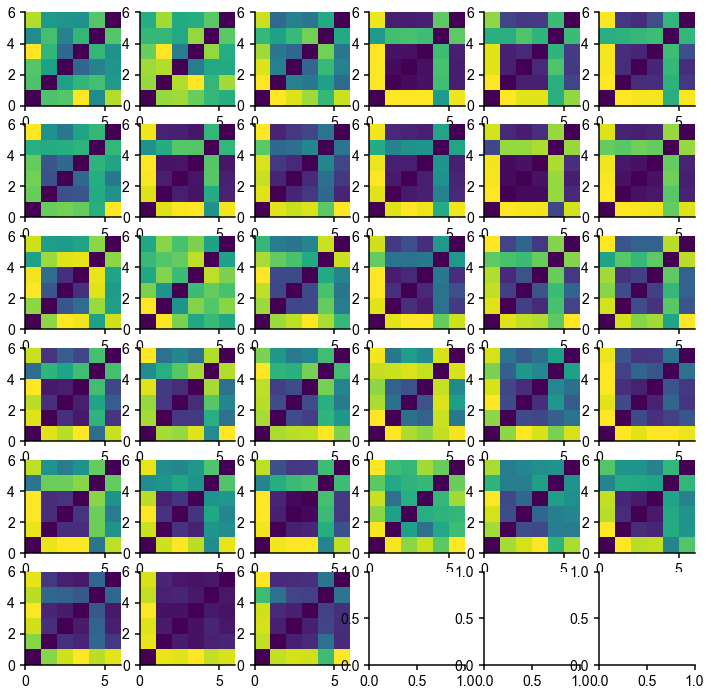

In [80]:
# computed session-wise (Fig. 2)
pairwise_dists, rda, session_avg_components, explained_var, trunc_class_labels = reduce(
    trunc_df, neuron_info, X_means_norm, class_name, protocol_info, colors, late_trace_ind, n_components)

In [81]:
svdf = trunc_df.copy()
svdf[['var1', 'var2']] = 0
svdf[['var1', 'var2']] = np.vstack([v for v in explained_var.values()])
msvdf = svdf.groupby('name').mean()  # average sessionwise pca across mice, then compute summary stats 
msvdf[['var1', 'var2']].agg(['mean', 'sem'])

<ipython-input-81-f3e02796670f>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  msvdf = svdf.groupby('name').mean()  # average sessionwise pca across mice, then compute summary stats


,var1,var2
mean,0.603039,0.213365
sem,0.020447,0.017291


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


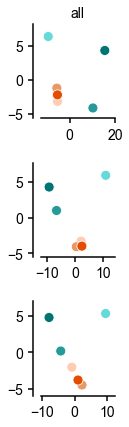

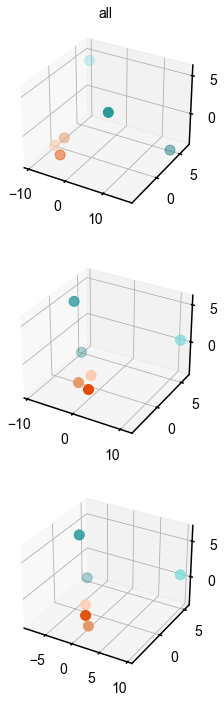

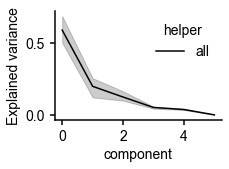

In [82]:
avg_dists, avg_rda = avg_session_dists(trunc_df, pairwise_dists, rda, class_labels, n_trace_types, trunc_class_labels, n_components)
mousewise_pca, mousewise_dists, mousewise_avg, mousewise_rda, mousewise_rdaavg, mousewise_var = reduce_mouse_avg(
    neuron_info, X_means_norm, class_name, class_labels, mice, protocol_info, colors, class_colors, late_trace_ind, n_components)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


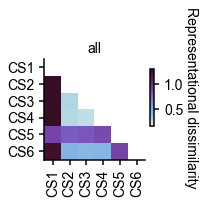

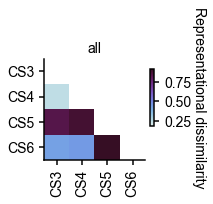

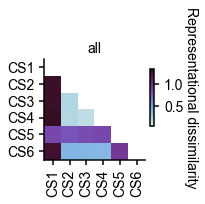

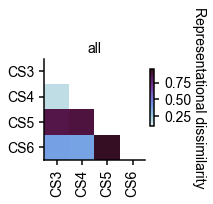

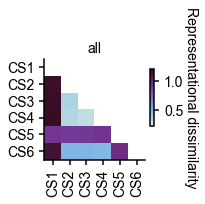

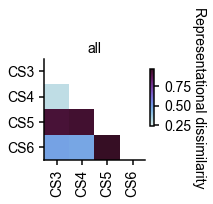

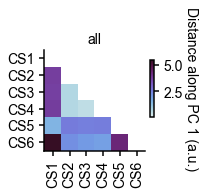

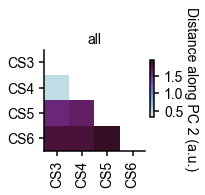

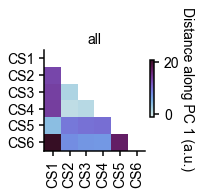

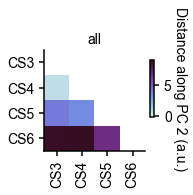

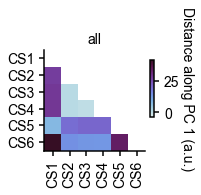

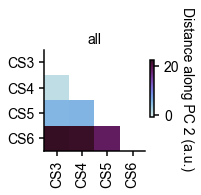

In [83]:
plot_masked_mat(avg_rda, 0, 0, class_labels, 'avg_rda', protocol_info)
plot_masked_mat(avg_rda, 0, 2, class_labels, 'avg_rda', protocol_info)
plot_masked_mat(mousewise_rdaavg, 0, 0, class_labels, 'mouseavg_rda', protocol_info)
plot_masked_mat(mousewise_rdaavg, 0, 2, class_labels, 'mouseavg_rda', protocol_info)
plot_masked_mat(pooled_rdaavg, 0, 0, class_labels, 'pooledavg_rda', protocol_info)
plot_masked_mat(pooled_rdaavg, 0, 2, class_labels, 'pooledavg_rda', protocol_info)
plot_masked_mat(avg_dists, 0, 0, class_labels, 'avg_dists', protocol_info)
plot_masked_mat(avg_dists, 1, 2, class_labels, 'avg_dists', protocol_info)
plot_masked_mat(mousewise_avg, 0, 0, class_labels, 'mousewise_avg', protocol_info)
plot_masked_mat(mousewise_avg, 1, 2, class_labels, 'mousewise_avg', protocol_info)
plot_masked_mat(pooled_avg, 0, 0, class_labels, 'pooled_avg', protocol_info)
plot_masked_mat(pooled_avg, 1, 2, class_labels, 'pooled_avg', protocol_info)

In [56]:
if class_name != 'lesion':
    subsets = ['all', 'pess', 'opt'] if table == 'imaging' else ['all']
    df_list, code_order, info, reduced_activities, all_dists, all_rda = generate_model_predictions(
        protocol_info, colors, cat=True, noise_scale=5, subsets=subsets)
    if table == 'ephys':
        compute_model_rsa(ret_df, code_order, all_dists, all_rda, pairwise_dists, rda, mousewise_dists, mousewise_rda, mouse_colors, protocol)

2
[-1.  1.  3.  5.  7.]
1.0
[0. 2. 4. 6.]
[array([1., 0., 0., 0.]), array([0.8, 0. , 0. , 0.2]), array([0.5, 0. , 0. , 0.5]), array([0.2, 0. , 0. , 0.8]), array([0., 0., 0., 1.])]
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[0 1]
[2 3]
[[0.17391304 0.4137931  0.57142857 0.68292683 0.76595745 0.83018868
  0.88135593 0.92307692 0.95774648 0.98701299]
 [0.01298701 0.04225352 0.07692308 0.11864407 0.16981132 0.23404255
  0.31707317 0.42857143 0.5862069  0.82608696]]


KeyboardInterrupt: 

# CCGP, pairwise, congruency, and odor decoding analyses
## Generated plots include Fig. 2c, 3i-k, 4h, and ED Fig. 2i-l, 3, 4a-c, 8h-j.
#### Training and testing on the Late Trace period corresponds to `per_key = '3_3'`
#### Run this only on `fig2`, `fig3`, `fig4`, or `EDfig8`, otherwise it will break because it doesn't have the 2x2 structure

In [17]:
# parameters for decoding
pers_base = [1, 2, 3]
train_pers = np.repeat(pers_base, len(pers_base))
test_pers = np.tile(pers_base, len(pers_base))

per_keys = ['_'.join([str(train_per), str(test_per)]) for train_per, test_per in zip(train_pers, test_pers)]
use_pop = 'max'
reg_C = 5e-3
n_splits = 6

dec_path = os.path.join(paths['neural_fig_roots'][1], '_'.join([protocol, 'dec_dict', table, spec, activity_type, class_name, 
                                                str(n_splits), str(reg_C), hashed + '.p']))

In [18]:
if os.path.exists(dec_path):
    print(f'Found dec_path at {dec_path}. Loading requires at least {os.path.getsize(dec_path) / (1024**3):.2f} additional GB RAM')
    with open(dec_path, 'rb') as f:
        dec_dict = pickle.load(f)
else:
    print(f'Could not find dec_path at {dec_path}. If you did not intend to run your own decoding, please copy the data from the data repo.')
    dec_dict = dec_dict_setup(cue_resps, all_spk_cnts[:n_trace_types] / psth_bin_width, psth_bin_centers,
                          protocol_info, kwargs, train_pers=train_pers, test_pers=test_pers)

    dec_dict = pseudo_decode_by_class(class_name, class_labels, dec_dict, neuron_info, rois,
                                  n_splits=n_splits, by_mouse=bm, match_across_class=mac, 
                                  match_across_reg=mar, reg_C=reg_C, do_zscore=True)  # zscore only within test set, rather than whole session

    print('starting simultaneous decoding')
    for shuff in [False, True]:  # right now, shuff only runs for period '3_3'
        dec_dict = simul_decode_by_class(class_name, class_labels, dec_dict, neuron_info, rois, reg_C=reg_C,
                                         do_zscore=True, shuffle=shuff)  # zscore only within test set, rather than whole session 
    with open(dec_path, 'wb') as f:
        pickle.dump(dec_dict, f)

Found dec_path at ../../data/neural-plots/SameRewDist_dec_dict_ephys_combined_striatum_spks_helper_6_0.005_b7437f9cb619f562f224c5af16a0ce35.p. Loading requires at least 16.67 additional GB RAM


In [25]:
dec_dict = make_dfs(class_name, class_labels, dec_dict, rois, by_mouse=bm, pseudo=True)
dec_dict = make_dfs(class_name, class_labels, dec_dict, rois, by_mouse=True, pseudo=False)

ccgp
pair
cong
mean
odor
ccgp
pair
cong
mean
odor
ccgp
pair
cong
mean
odor


In [26]:
for per_key in per_keys:
    dec_dict = run_stats(class_name, class_labels, rois, dec_dict, per_key, by_mouse=bm)

ccgp
disagg
pool
pair
disagg
AL101
Accuracy ~ C(Subregion) * C(grouping)
Accuracy ~ C(grouping)
No data for Subregion = VP between helper. Skipping
No data for Subregion = mAcbSh between helper. Skipping
Accuracy ~ C(grouping)
No data for Subregion = core between helper. Skipping
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
AL102
Accuracy ~ C(Subregion) * C(grouping)
No data for Subregion = OT between helper. Skipping
Accuracy ~ C(grouping)
No data for Subregion = mAcbSh between helper. Skipping
Accuracy ~ C(grouping)
No data for Subregion = core between helper. Skipping
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
AL103
Accuracy ~ C(Subregion) * C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
No data for Subregion = mAcbSh between helper. Skipping
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)

ccgp
ccgp [['#244b05', '#7cd411', '#4a9d05', '#2c6805'], ['#74B72E']] [['Distribution CCGP 1', 'Distribution CCGP 2', 'Distribution CCGP 3', 'Distribution CCGP 4'], ['ccgp']]
1_1
['ccgp']
Subregion ['All Subregions'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       25           Method:                  REML    
No. Groups:             5            Scale:                   0.0011  
Min. group size:        5            Log-Likelihood:          42.1756 
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.043e-02 1.668e-

/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publis

1_2
['ccgp']
Subregion ['All Subregions'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       25           Method:                  REML    
No. Groups:             5            Scale:                   0.0018  
Min. group size:        5            Log-Likelihood:          37.8696 
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.457e-02 1.447e-02 1.007e+00 3.140e-01 -1.379e-02 4.294e-02
mouse Var 6.814e-04 1.896e-02                                         

[0] [0.314]


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


1_3
['ccgp']
Subregion ['All Subregions'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       25           Method:                  REML    
No. Groups:             5            Scale:                   0.0012  
Min. group size:        5            Log-Likelihood:          40.1643 
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.075e-03 2.228e-02 9.312e-02 9.258e-01 -4.160e-02 4.575e-02
mouse Var 2.237e-03 5.494e-02                                         

[0] [0.9258]


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


2_1
['ccgp']
Subregion ['All Subregions'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      25           Method:                  REML    
No. Groups:            5            Scale:                   0.0011  
Min. group size:       5            Log-Likelihood:          44.3118 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.548e-02 1.135e-02 2.245e+00 2.476e-02 3.235e-03 4.771e-02
mouse Var 4.318e-04 1.532e-02                                        

[0] [0.02476]


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_2
['ccgp']
Subregion ['All Subregions'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       25           Method:                  REML    
No. Groups:             5            Scale:                   0.0010  
Min. group size:        5            Log-Likelihood:          42.2536 
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 5.475e-03 1.952e-02 2.804e-01 7.792e-01 -3.279e-02 4.374e-02
mouse Var 1.696e-03 4.561e-02                                         

[0] [0.7792]


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


KeyboardInterrupt: 

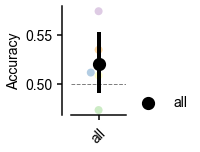

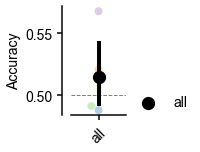

Error in callback <function flush_figures at 0x14559bfc1d30> (for post_execute):


KeyboardInterrupt: 

In [28]:
if table == 'imaging':
    plot_decode_by_class(class_name, class_labels, dec_dict, per_keys, rois, pseudo=psd,
                         n_splits=n_splits, class_colors=class_colors, activity_type=activity_type)
else:
    plot_mouse_decode_by_class(class_name, class_labels, dec_dict, per_keys=per_keys, rois=['All Subregions'],
                           pseudo=psd, n_splits=n_splits, mouse_colors=mouse_colors, class_colors=class_colors,
                           test='lme', activity_type=activity_type)

    # Beware, plotting this part below takes a long time (~30 minutes), and is not necessary for later 
    # analyses. when plotting across subregions, use pseudo-populations to match neuron counts
    if class_name == 'helper':
        plot_mouse_decode_by_class(class_name, class_labels, dec_dict, per_keys, rois, pseudo=True,
                                   n_splits=n_splits, mouse_colors=mouse_colors, class_colors=class_colors, reg_C=reg_C, test='lme')

1_1


meta NOT subset; don't know how to subset; dropped


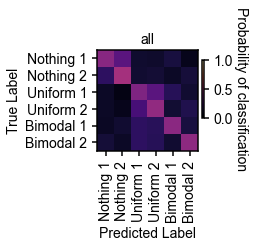

In [29]:
# odor decoding
if table == 'ephys':
    plot_avg_confusion_mat_by_class(class_name, class_labels, dec_dict, ['1_1'], n_trace_types, protocol_info, 
                                    pseudo=psd, activity_type=activity_type, mouse_colors=mouse_colors, class_colors=class_colors)

## Close the loop on PCA analysis now that we have `dec_dict`

pca mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist    
No. Observations:      32           Method:                  REML    
No. Groups:            5            Scale:                   1.8114  
Min. group size:       4            Log-Likelihood:          -58.0735
Max. group size:       8            Converged:               Yes     
Mean group size:       6.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.284e+00 5.309e-01 4.302e+00 1.695e-05 1.243e+00 3.324e+00
mouse Var 1.111e+00 7.944e-01                                     

/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01

pca pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist    
No. Observations:       32           Method:                  REML    
No. Groups:             5            Scale:                   0.4050  
Min. group size:        4            Log-Likelihood:          -35.1030
Max. group size:        8            Converged:               Yes     
Mean group size:        6.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 5.550e-02 2.671e-01 2.078e-01 8.354e-01 -4.681e-01 5.791e-01
mouse Va

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pca odor ['all']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Bimodal', 'Nothing vs. Uniform']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
0 1 1 1
dist ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       dist    
No. Observations:        32            Method:                   REML    
No. Groups:              5             Scale:                    1.0943  
Min. group size:         4             Log-Likelihood:           -51.7430
Max. group size:         8             Converged:                Yes     
Mean group size:         6.4                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -1.419e+00 5.975e-01 -2.375e+00 1.757e-0

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_pca mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist    
No. Observations:      5            Method:                  REML    
No. Groups:            5            Scale:                   1.2531  
Min. group size:       1            Log-Likelihood:          -11.9976
Max. group size:       1            Converged:               Yes     
Mean group size:       1.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 6.544e+00 1.776e+00 3.684e+00 2.298e-04 3.062e+00 1.003e+01
mouse Var 1.452e+01                                         

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_pca pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist    
No. Observations:       5            Method:                  REML    
No. Groups:             5            Scale:                   0.5280  
Min. group size:        1            Log-Likelihood:          -10.1834
Max. group size:        1            Converged:               Yes     
Mean group size:        1.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 4.059e-01 1.129e+00 3.596e-01 7.191e-01 -1.806e+00 2.618e+00
mo

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_pca odor ['all']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Bimodal', 'Nothing vs. Uniform']


/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


['Nothing vs. Bimodal', 'Nothing vs. Uniform']
0 1 1 1
dist ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       dist    
No. Observations:        5             Method:                   REML    
No. Groups:              5             Scale:                    1.0262  
Min. group size:         1             Log-Likelihood:           -11.8232
Max. group size:         1             Converged:                Yes     
Mean group size:         1.0                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -4.038e+00 1.701e+00 -2.375e+00 1.757e-02 -7.371e+00 -7.051e-01
mouse Var  1.343e+01                                                     

[0.5] [0.01757]


meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_pca mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
stat = 28.2859, pval = 0.0001
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      dist   
No. Observations:        4            Method:                  REML   
No. Groups:              4            Scale:                   0.1232 
Min. group size:         1            Log-Likelihood:          -6.0590
Max. group size:         1            Converged:               Yes    
Mean group size:         1.0                                          
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|      [0.025    0.975] 
----------------------------------------------------------------------
Intercept 2.047e+01 7.236e-01 2.829e+01 5.158e-176 1.905e+01 2.189e+01
mouse Var 1.971e+00

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_pca pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
stat = -1.6384, pval = 0.1999
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                 Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       dist   
No. Observations:        4             Method:                   REML   
No. Groups:              4             Scale:                    0.1071 
Min. group size:         1             Log-Likelihood:           -5.8485
Max. group size:         1             Converged:                Yes    
Mean group size:         1.0                                            
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.105e+00 6.

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_pca odor ['all']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Bimodal', 'Nothing vs. Uniform']
stat = -27.8835, pval = 0.0001
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
0 1 1 1
dist ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        dist   
No. Observations:        4              Method:                    REML   
No. Groups:              4              Scale:                     0.0493 
Min. group size:         1              Log-Likelihood:            -4.1708
Max. group size:         1              Converged:                 Yes    
Mean group size:         1.0                                              
--------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|      [0.025     0.975]  
--------------------------------------------------------------------------
Int

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

rda mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      dist  
No. Observations:        32           Method:                  REML  
No. Groups:              5            Scale:                   0.0353
Min. group size:         4            Log-Likelihood:          2.6203
Max. group size:         8            Converged:               Yes   
Mean group size:         6.4                                         
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 6.095e-01 8.049e-02 7.573e+00 3.642e-14 4.518e-01 7.673e-01
mouse Var 2.651e-02 1.348e-01                                     

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

rda pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                 Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       dist   
No. Observations:        32            Method:                   REML   
No. Groups:              5             Scale:                    0.0080 
Min. group size:         4             Log-Likelihood:           26.2014
Max. group size:         8             Converged:                Yes    
Mean group size:         6.4                                            
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -3.701e-03 3.335e-02 -1.110e-01 9.116e-01 -6.906e-

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

rda odor ['all']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Bimodal', 'Nothing vs. Uniform']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
0 1 1 1
dist ~ 1
                 Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       dist   
No. Observations:        32            Method:                   REML   
No. Groups:              5             Scale:                    0.0101 
Min. group size:         4             Log-Likelihood:           22.1130
Max. group size:         8             Converged:                Yes    
Mean group size:         6.4                                            
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -5.337e-02 4.227e-02 -1.263e+00 2.067e-01 -1.362e-

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_rda mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist   
No. Observations:       5            Method:                  REML   
No. Groups:             5            Scale:                   0.0043 
Min. group size:        1            Log-Likelihood:          -0.7266
Max. group size:        1            Converged:               Yes    
Mean group size:        1.0                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 6.534e-01 1.061e-01 6.157e+00 7.405e-10 4.454e-01 8.614e-01
mouse Var 5.198e-02 2.882e+07                               

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_rda pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                 Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       dist  
No. Observations:         5             Method:                   REML  
No. Groups:               5             Scale:                    0.0001
Min. group size:          1             Log-Likelihood:           3.9768
Max. group size:          1             Converged:                Yes   
Mean group size:          1.0                                           
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -2.519e-03 3.274e-02 -7.693e-02 9.387e-01 -6

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_rda odor ['all']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Bimodal', 'Nothing vs. Uniform']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
0 1 1 1
dist ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        dist  
No. Observations:        5              Method:                    REML  
No. Groups:              5              Scale:                     0.0005
Min. group size:         1              Log-Likelihood:            3.3924
Max. group size:         1              Converged:                 Yes   
Mean group size:         1.0                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -7.452e-02 3.789e-02 -1.967e+00 4.

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_rda mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
stat = 40.5820, pval = 0.0000
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      dist  
No. Observations:        4            Method:                  REML  
No. Groups:              4            Scale:                   0.0001
Min. group size:         1            Log-Likelihood:          5.7551
Max. group size:         1            Converged:               Yes   
Mean group size:         1.0                                         
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 5.722e-01 1.410e-02 4.058e+01 0.000e+00 5.446e-01 5.999e-01
mouse Var 7.158e-04 5.529e+06

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_rda pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
stat = -2.9733, pval = 0.0589
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        dist  
No. Observations:        4              Method:                    REML  
No. Groups:              4              Scale:                     0.0002
Min. group size:         1              Log-Likelihood:            7.3865
Max. group size:         1              Converged:                 Yes   
Mean group size:         1.0                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -2.

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_rda odor ['all']
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Bimodal', 'Nothing vs. Uniform']
stat = -11.9016, pval = 0.0013
['Nothing vs. Bimodal', 'Nothing vs. Uniform']
0 1 1 1
dist ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        dist  
No. Observations:        4              Method:                    REML  
No. Groups:              4              Scale:                     0.0000
Min. group size:         1              Log-Likelihood:            9.4486
Max. group size:         1              Converged:                 Yes   
Mean group size:         1.0                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -4

meta NOT subset; don't know how to subset; dropped


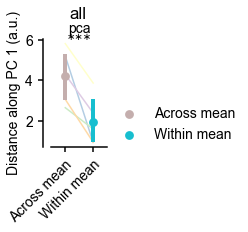

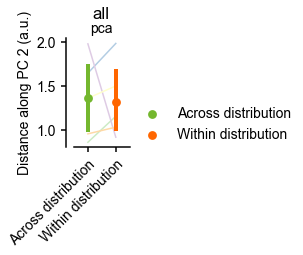

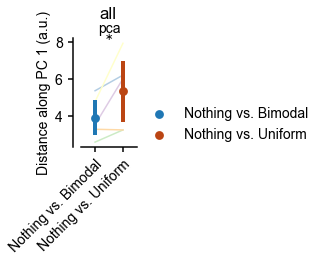

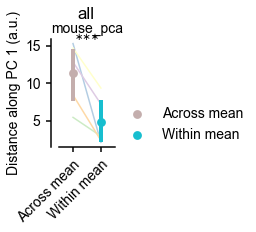

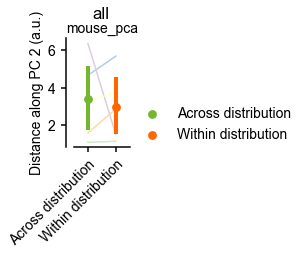

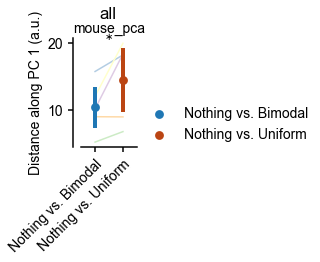

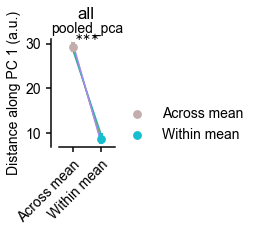

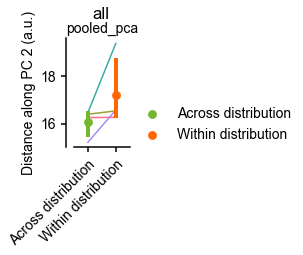

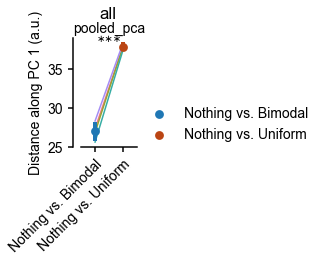

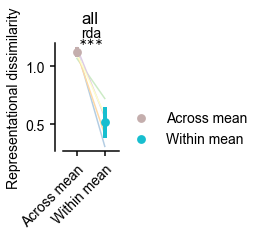

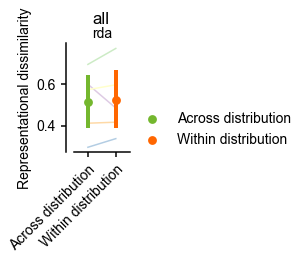

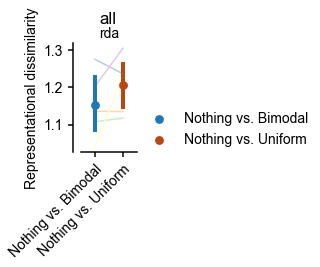

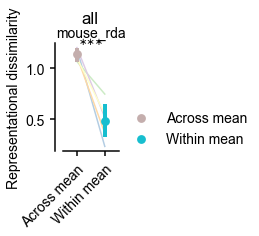

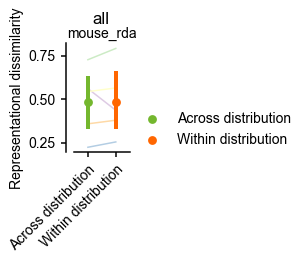

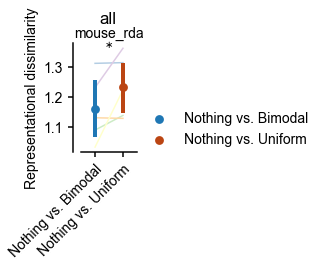

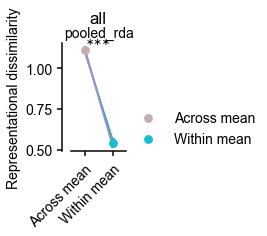

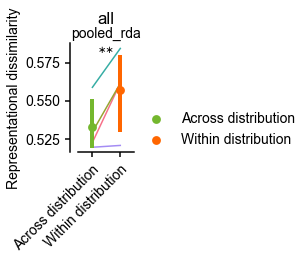

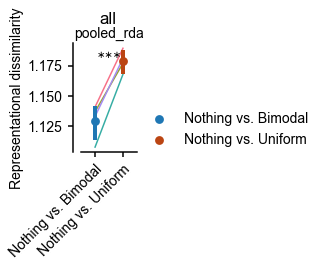

In [30]:
if 'Same' in protocol:  # can't run this for Bernoulli or DiverseDists
    if table == 'imaging':
        sess_class_labels = np.empty(len(ret_df), dtype=object)
        for index, row in ret_df.iterrows():
            cell_inds = np.logical_and(neuron_info['fig_paths'] == row['figure_path'], ~neuron_info[class_name].isnull())
            sess_class_label = np.unique(neuron_info.loc[cell_inds, class_name])
            assert len(sess_class_label) == 1
            sess_class_labels[index] = sess_class_label[0]
            
        reduce_stats(pairwise_dists, mousewise_dists, pooled_dists, rda, mousewise_rda, pooled_rda, ret_df, dec_dict, 
                 protocol_info, class_name, class_labels, sess_class_labels, mice, mouse_colors,
                 n_components, trunc_df, trunc_class_labels, n_splits=n_pca_splits, activity_type=activity_type)
    else:
        reduce_stats(pairwise_dists, mousewise_dists, pooled_dists, rda, mousewise_rda, pooled_rda, ret_df, dec_dict, 
                 protocol_info, class_name, class_labels, trunc_class_labels, mice, mouse_colors,
                 n_components, n_splits=n_pca_splits, activity_type=activity_type)

### Decoder angles, ED Fig. 3f-g.

In [31]:
if protocol == 'SameRewDist' and table == 'ephys' and class_name == 'helper':
    # do a straightforward, no frills PCA on the late cue resps
    n_components = 3
    pca = PCA(n_components=n_components)
    components = {}
    fig, axs = plt.subplots(1, len(class_labels), figsize=(2.5*len(class_labels), 2), squeeze=False)
    for i_cls, class_label in enumerate(class_labels):
        projection = pca.fit_transform(X_means_norm[:n_trace_types, neuron_info[class_name] == class_label, late_trace_ind])
        components[class_label] = pca.components_
        
        ax = axs[0, i_cls]
        ax.scatter(projection[:, 0], projection[:, 1], color=colors['colors'][:n_trace_types])
        ax.set_xlabel('Projection onto PC1')
        ax.set_ylabel('Projection onto PC2')
        ax.set_ylim(np.array(ax.get_ylim())*1.2)
        ax.set_xlim(np.array(ax.get_xlim())*1.2)
    #     ax.set_title(class_label)
    
    fig.tight_layout()
    hide_spines()

In [32]:
if protocol == 'SameRewDist' and table == 'ephys' and class_name == 'helper':

    print('Computing angles. This may take a long time.')
    angle_df, control_df = compute_angles(dec_dict, neuron_info, cue_resps, protocol_info, components,
                                      session_avg_components, ret_df, class_name, class_labels, rois, 
                                      n_splits=n_splits, train_per=3, test_per=3, do_zscore=True)
    print('Plotting...')
    plot_decoder_angles(dec_dict['per'], control_df, angle_df, class_name, class_labels, ['All Subregions'], n_components,
                    mouse_colors=mouse_colors, dec_types=['simul'])

# Parallelism score
## Generated plots include Fig. 2b, 3g, ED Figure 4d
#### Run this only on `fig2`, `fig3`, `fig4`, or `EDfig8`, otherwise it will break because it doesn't have the 2x2 structure

all
['parallel']
Subregion ['All Subregions'] grouping ['parallel'] helper ['all']
1 All Subregions
['parallel']
0 0 1 1
Parallelism ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Parallelism
No. Observations:      62          Method:                 REML       
No. Groups:            5           Scale:                  0.0758     
Min. group size:       8           Log-Likelihood:         -14.2626   
Max. group size:       16          Converged:              Yes        
Mean group size:       12.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 5.312e-02 1.045e-01 5.084e-01 6.112e-01 -1.517e-01 2.579e-01
mouse Var 4.815e-02 1.416e-01                                         

[0] [0.6112]


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['dec_key'] = 'all'
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

['parallel']
Subregion ['All Subregions'] grouping ['parallel'] helper ['all']
2 All Subregions
['parallel']
0 0 1 1
Parallelism ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Parallelism
No. Observations:      62          Method:                 REML       
No. Groups:            5           Scale:                  0.0354     
Min. group size:       8           Log-Likelihood:         7.8008     
Max. group size:       16          Converged:              Yes        
Mean group size:       12.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.442e-02 9.637e-02 2.534e-01 7.999e-01 -1.645e-01 2.133e-01
mouse Var 4.343e-02 1.786e-01                                         

[0] [0.7999]


meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['dec_key'] = 'all'
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/

['parallel']
Subregion ['All Subregions'] grouping ['parallel'] helper ['all']
3 All Subregions
['parallel']
0 0 1 1
Parallelism ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Parallelism
No. Observations:      62          Method:                 REML       
No. Groups:            5           Scale:                  0.0563     
Min. group size:       8           Log-Likelihood:         -5.0953    
Max. group size:       16          Converged:              Yes        
Mean group size:       12.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 3.375e-03 8.838e-02 3.819e-02 9.695e-01 -1.699e-01 1.766e-01
mouse Var 3.429e-02 1.176e-01                                         

[0] [0.9695]


meta NOT subset; don't know how to subset; dropped


all
['parallel']
helper ['all'] Subregion ['OT', 'VP', 'mAcbSh', 'lAcbSh', 'core', 'VMS', 'VLS', 'DMS', 'DLS', 'All Subregions'] grouping ['parallel']


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['dec_key'] = 'all'
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

1 OT
['parallel']
0 0 1 1
Parallelism ~ 1
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Parallelism
No. Observations:      30           Method:                  REML       
No. Groups:            3            Scale:                   0.0682     
Min. group size:       10           Log-Likelihood:          -4.3636    
Max. group size:       10           Converged:               Yes        
Mean group size:       10.0                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -5.485e-02 5.952e-02 -9.215e-01 3.568e-01 -1.715e-01 6.181e-02
mouse Var  3.805e-03 4.217e-02                                          

[0] [0.3568]
1 VP
['parallel']
0 0 1 1
Parallelism ~ 1
                Mixed Linear Model Regressio

meta NOT subset; don't know how to subset; dropped


['parallel']
helper ['all'] Subregion ['OT', 'VP', 'mAcbSh', 'lAcbSh', 'core', 'VMS', 'VLS', 'DMS', 'DLS', 'All Subregions'] grouping ['parallel']


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['dec_key'] = 'all'
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

2 OT
['parallel']
0 0 1 1
Parallelism ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Parallelism
No. Observations:      30          Method:                 REML       
No. Groups:            3           Scale:                  0.0401     
Min. group size:       10          Log-Likelihood:         2.1979     
Max. group size:       10          Converged:              Yes        
Mean group size:       10.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 9.406e-03 8.151e-02 1.154e-01 9.081e-01 -1.504e-01 1.692e-01
mouse Var 1.593e-02 1.032e-01                                         

[0] [0.9081]
2 VP
['parallel']
0 0 1 1
Parallelism ~ 1
                Mixed Linear Model Regression Results
Model:       

meta NOT subset; don't know how to subset; dropped


['parallel']
helper ['all'] Subregion ['OT', 'VP', 'mAcbSh', 'lAcbSh', 'core', 'VMS', 'VLS', 'DMS', 'DLS', 'All Subregions'] grouping ['parallel']


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2652: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['dec_key'] = 'all'
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

3 OT
['parallel']
0 0 1 1
Parallelism ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Parallelism
No. Observations:      30          Method:                 REML       
No. Groups:            3           Scale:                  0.0423     
Min. group size:       10          Log-Likelihood:         2.9961     
Max. group size:       10          Converged:              Yes        
Mean group size:       10.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 3.960e-02 3.757e-02 1.054e+00 2.919e-01 -3.404e-02 1.132e-01
mouse Var 6.921e-12 7.820e-02                                         

[0] [0.2919]
3 VP
['parallel']
0 0 1 1
Parallelism ~ 1
                Mixed Linear Model Regression Results
Model:       

meta NOT subset; don't know how to subset; dropped


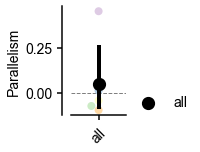

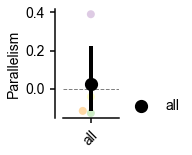

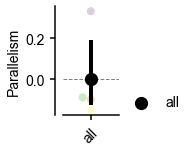

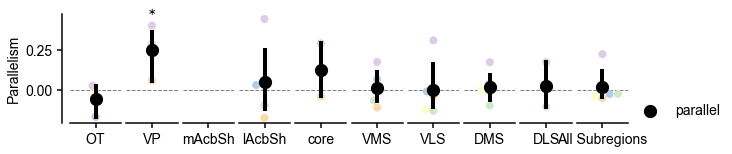

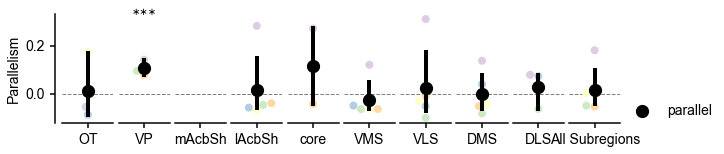

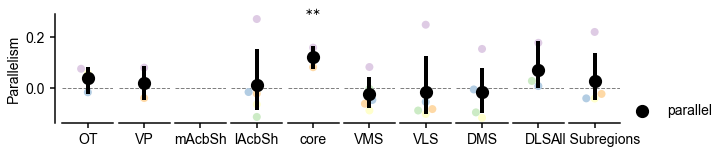

In [33]:
if table == 'ephys' and 'Same' in protocol:
    
    simul_ps_resps = compute_parallelism_split_interaction_by_class(
        class_name, class_labels, neuron_info, cue_resps_norm, periods, rois=['All Subregions'], use_size=100)
    
    simul_ps = plot_parallelism_interaction_by_class(
        class_name, simul_ps_resps, periods, rois=['All Subregions'], mouse_colors=mouse_colors, 
        class_colors=class_colors, activity_type=activity_type)
    
    if class_name == 'helper':
        # only for comparison across subregions in ED Fig. 4d
        pseudo_ps_resps = compute_parallelism_split_interaction_by_class(
            class_name, class_labels, neuron_info, cue_resps_norm, periods, rois, use_size=40, pseudo=True)
        
        pseudo_ps = plot_parallelism_interaction_by_class(
            class_name, pseudo_ps_resps, periods, rois=rois, mouse_colors=mouse_colors,
            class_colors=class_colors, pseudo=True, activity_type=activity_type)

# Single-neuron correlations
## Generated plots include Fig. 4e-f, ED Fig. 2c-d, f-h, m-r, 7o, 8f.
#### No need to run this for `plot_fig = 'fig3'`

In [58]:
trace_dict = {'cs_in': 0,
    'cs_out': 1,
    'trace_end': 3,
    'xlim': (-1, 5),
    'ylabel': '',
    'xlabel': 'Time from CS (s)'
}

sign_labels = ['Positive', 'Negative']
sign_colors = {'Negative': '#BA55D3', 'Positive': '#0047AB'}

In [59]:
# can also examine other use_keys, like ['resid_var', 'resid_cvar', 'var', 'cvar',
# 'nolick_mean', 'resid_mean', 'rew'], but some of these only exist for SameRewDist right now
use_keys = ['mean', 'rpe']   # ]  # corr_keys
use_inds = None  # use all neurons
# # restrict to MSNs
# use_inds = neuron_info['cell_types'] == 'MSN'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for use_corrs, n_bins, timebase in zip([corrs, corrs_seconds], [n_psth_bins, n_periods], [psth_bin_centers, np.arange(-.5, 4)]):                
        use_corrs = compute_sig_frac_by_class('str_regions', rois, use_corrs, neuron_info, use_keys, n_bins, inds=use_inds)

In [60]:
use_corrs = corrs  # corrs_seconds
use_bin_centers = psth_bin_centers

lt_start = 2
lt_end = rew_start = 3
rew_end = 4

start_ind, end_ind = get_start_end_inds(use_corrs, corrs, corrs_seconds, psth_bin_centers, lt_start, lt_end, late_trace_ind)

time_df, frac_df, diff_df, mouse_time_df, mouse_frac_df, mouse_diff_df = compute_sig_frac_sess_df(
    use_corrs, psth_bin_centers, use_keys, class_name, class_labels, sign_labels, mice, neuron_info, lt_start, lt_end,
    rew_start, rew_end, min_size=10)

mean Positive all
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      fracs   
No. Observations:      27           Method:                  REML    
No. Groups:            3            Scale:                   22.6190 
Min. group size:       4            Log-Likelihood:          -80.4550
Max. group size:       13           Converged:               Yes     
Mean group size:       9.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 6.842e+00 1.974e+00 3.467e+00 5.269e-04 2.974e+00 1.071e+01
names Var 8.561e+00 2.577e+00                                        



/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


rpe Positive all
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      fracs   
No. Observations:      27           Method:                  REML    
No. Groups:            3            Scale:                   61.5674 
Min. group size:       4            Log-Likelihood:          -92.1021
Max. group size:       13           Converged:               Yes     
Mean group size:       9.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.661e+01 1.416e+00 1.173e+01 9.200e-32 1.383e+01 1.938e+01
names Var 1.478e-08                                                  



meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


mean Negative all
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      fracs   
No. Observations:      27           Method:                  REML    
No. Groups:            3            Scale:                   32.4873 
Min. group size:       4            Log-Likelihood:          -84.8026
Max. group size:       13           Converged:               Yes     
Mean group size:       9.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.854e+00 1.951e+00 2.488e+00 1.286e-02 1.030e+00 8.678e+00
names Var 7.258e+00 1.882e+00                                        

rpe Negative all
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      fracs   
No. Observations

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


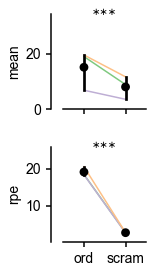

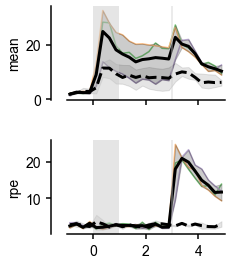

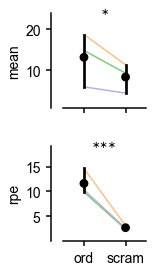

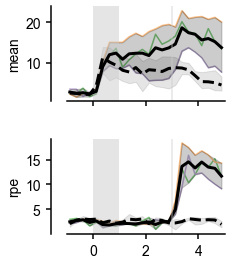

In [61]:
plot_sig_frac_sess_by_class(class_name, class_labels, mouse_time_df, mouse_frac_df, diff_df, use_keys, sign_labels, 
                            trace_dict, protocol, mouse_colors, activity_type='spks')

/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:291: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_df = diff_df.groupby(['names', 'keys', 'sign', class_name], as_index=False).mean()
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uch

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      fracs   
No. Observations:      27           Method:                  REML    
No. Groups:            3            Scale:                   22.6190 
Min. group size:       4            Log-Likelihood:          -80.4550
Max. group size:       13           Converged:               Yes     
Mean group size:       9.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 6.842e+00 1.974e+00 3.467e+00 5.269e-04 2.974e+00 1.071e+01
names Var 8.561e+00 2.577e+00                                        

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      fracs   
No. Observations:      27           Method:        

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


[0.08676818442181163, 0.11026082594100246]
[7.155564606122255, 5.667940415722224]
[2.2574177126269093, 2.05617047879862]
[0.04824174507246687, 0.05987623902688527]
[-0.5278696705435775, -0.4562303573644457]
[0.12033988073803577, 0.11695697484965566]


meta NOT subset; don't know how to subset; dropped


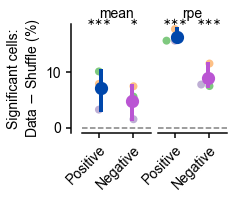

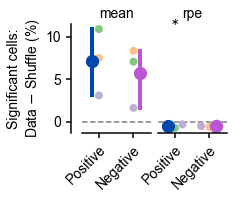

In [62]:
# replot data from above, more cleanly, just the basics
plot_sig_frac_sess_lme(diff_df, use_keys, class_name, sign_labels, mouse_colors, sign_colors, protocol)

plot_sig_frac_mouse_ttest(use_corrs, use_keys, class_name, class_labels, sign_labels, start_ind, end_ind,
                          mouse_colors, sign_colors, protocol, min_size=40)

In [63]:
if plot_fig == 'fig2':
    plot_conjunction_sig_frac_sess_by_class(neuron_info, corrs, protocol, mouse_colors)

## ED Figure 10a-b, d-e

In [ ]:
if plot_fig == 'fig4':
    
    ########## 10a-b. Slight differences result from using un-smoothed timecourse   #############
    # cs_subtimecourse_norm = (cs_subtimecourse - np.array(np.nanmean(cs_subtimecourse, axis=(0, 2))).reshape(1, -1, 1)) / np.array(
    # np.nanstd(cs_subtimecourse, axis=(0, 2))).reshape(1, -1, 1)
    # sigma_s = 0.100  # 100 ms
    # cs_subtimecourse_norm[exclude_tt, :, std_time < timestamps['stim'] + sigma_s*3] = np.nan

    # for class_label in class_labels:
    #     val = neuron_info[class_name] == class_label
    #     suffix = '_' + class_label + '_neurons_sorted_cs' + str(n_trace_types)
    #     timecourse = cs_subtimecourse_norm[:, val, ::ds_factor]
    #     sort_sub_peak_inds = np.argsort(peak_inds[val])
    #     label_heatmap(n_trial_types, protocol_info['trial_type_names'], pcolor_time,
    #                   timecourse[pou][:, sort_sub_peak_inds, :], colors['colors'][pou],
    #                   total_cells, paths, suffix, 'firing')
    #     plt.suptitle(class_label)

    ########### 10d. Differences relative to baseline. ###########
    
    baseline_ind = 0
    rstats = np.zeros((2, total_cells))
    rps = np.zeros((2, total_cells))
    # baseline_reps > lt_resps --> statistic is negative
    # lt_resps > baseline_resps --> statistic is positive
    for i, type_range in enumerate([np.array([0, 1]), np.arange(2, n_trace_types)]):
        for i_cell in range(total_cells):
            baseline_resps = cue_resps[type_range, i_cell, :, baseline_ind]
            lt_resps = cue_resps[type_range, i_cell, :, late_trace_ind]
            rstats[i, i_cell], rps[i, i_cell] = stats.ranksums(
                lt_resps[~np.isnan(lt_resps)], baseline_resps[~np.isnan(baseline_resps)])
            
    neuron_info[['unrew_rstat', 'rew_rstat']] = rstats.T
    neuron_info[['unrew_sig_inc', 'rew_sig_inc']] = np.logical_and(rps < alpha, rstats > 0).T
    neuron_info[['unrew_sig_dec', 'rew_sig_dec']] = np.logical_and(rps < alpha, rstats < 0).T

    mouse_agg = neuron_info.groupby(['genotype', 'names'], as_index=False).mean().melt(
        id_vars=['genotype', 'names'], value_vars=['unrew_sig_inc', 'rew_sig_inc', 'unrew_sig_dec', 'rew_sig_dec'], var_name='sig', value_name='frac')
    mouse_agg['rew'] = ~mouse_agg['sig'].str.contains('unrew')
    mouse_agg['inc'] = mouse_agg['sig'].str.contains('inc')

    col_order = class_labels
    tests = {k: {False: 1, True: 1} for k in col_order}
    for col in col_order:
        for inc in tests[col].keys():
            
            unrew = mouse_agg.loc[np.logical_and.reduce([
                mouse_agg[class_name] == col, mouse_agg['inc'] == inc, mouse_agg['rew'] == False]), 'frac']
            rew =  mouse_agg.loc[np.logical_and.reduce([
                mouse_agg[class_name] == col, mouse_agg['inc'] == inc, mouse_agg['rew'] == True]), 'frac']
            
            _, tests[col][inc] = stats.ttest_rel(unrew, rew)
            
            print(col, inc)
            print(np.mean(rew.values - unrew.values))
            print(stats.sem(rew.values - unrew.values))

    g = sns.relplot(data=mouse_agg, row='inc', col=class_name, x='rew', y='frac', hue='names', col_order=class_labels,
                palette=mouse_colors, kind='line', height=2, aspect=.65, legend=False, zorder=1).set_titles('inc {row_name} {col_name}')
    g.map_dataframe(sns.pointplot, x='rew', y='frac', hue='rew', palette=['#9467bd', '#33abf9'], errwidth=4, 
                    errorbar=('ci', 95))
    for i_row, row in enumerate([False, True]):
        for i_col, col in enumerate(col_order):
            plot_stars(g.axes[i_row, i_col], [0.5], [tests[col][row]])
    plt.savefig('figs/inc_dec_rel_baseline.pdf')

    ############# 10e. Variance across trial types   ###########
    
    neuron_info['tt_var'] = np.var(X_means_norm[:n_trace_types, :, late_trace_ind], axis=0)
    sess_var = neuron_info.groupby(['names', 'file_dates', 'fig_paths', 'genotype'], as_index=False).mean()
    mouse_var = sess_var.groupby(['names', 'genotype'], as_index=False).mean()

    plt.figure(figsize=(1.3, 2))
    sns.swarmplot(sess_var, x='genotype', y='tt_var', hue='names', palette=mouse_colors, order=class_labels, 
                  size=4, legend=False, zorder=0)
    sns.swarmplot(mouse_var, x='genotype', y='tt_var', hue='names', palette=mouse_colors, order=class_labels, 
                  size=8, legend=False, zorder=1)
    sns.pointplot(mouse_var, x='genotype', y='tt_var', hue='genotype', palette=class_colors, order=class_labels, 
                  hue_order=class_labels, scale=1.5, errwidth=4)
    plt.legend().remove()
    plt.ylabel('Variance (across\ntrial types)')
    plt.xticks([0, 1], ['D1', 'D2'])
    plt.xlabel('')
    hide_spines()
    plt.savefig('figs/variance_across_trial_types_{}.pdf'.format('_'.join(class_labels)))